In [ ]:
#Got Regime Change? Hidden Markov Models Reveal 


In [145]:
#data handling
import numpy as np
import pandas as pd

#data illustration
import matplotlib.pyplot as plt
import seaborn as sns

#market data
from pandas_datareader import data as pdr
import yfinance as yf

from datetime import datetime
from hmmlearn.hmm import GaussianHMM

In [146]:
#Range from Bush To Trump -- 
start_date = "1998-01-02"
end_date = datetime.today().strftime("%Y-%m-%d")

In [147]:
#Market Data
spy = yf.download(tickers="SPY", 
                  start=start_date, 
                  end=end_date, 
                  progress=False) #S&P500 -Market Conditions Benchmark

vix = yf.download(tickers="^VIX", 
                  start=start_date, 
                  end=end_date, 
                  progress=False) #Market Volatility is a function of liquidity

from pandas_datareader import data as pdr
dgs10 = pdr.DataReader(name="DGS10", 
                       data_source="fred", 
                       start=start_date, 
                       end=end_date) #Risk Conditions // Debt as a control mechanism


In [148]:
dgs10 = dgs10.rename(
    columns={"DGS10": "dgs10"}
)



spy = spy.loc[:, [('Close', 'SPY')]].rename(
   columns={'Close': "spy_adj_close"})

vix = vix.loc[:, [('Close', '^VIX')]].rename(
    columns={'Close': "vix"})



In [150]:
data = pd.concat([spy, vix, dgs10], axis=1) #merge data
data["dgs10"] = data["dgs10"].ffill()

data.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in data.columns
]

data.dropna()



,spy_adj_close,vix,dgs10
1998-01-02,60.025791,23.420000,5.67
1998-01-05,60.160389,24.360001,5.52
1998-01-06,59.199074,25.660000,5.49
1998-01-07,59.352871,25.070000,5.55
1998-01-08,58.833790,26.010000,5.49
...,...,...,...
2025-12-30,687.010010,14.330000,4.14
2025-12-31,681.919983,14.950000,4.18
2026-01-02,683.169983,14.510000,4.19
2026-01-05,687.719971,14.900000,4.17


In [151]:


print(data.head())
#print(data.info())

            spy_adj_close        vix  dgs10
1998-01-02      60.025791  23.420000   5.67
1998-01-05      60.160389  24.360001   5.52
1998-01-06      59.199074  25.660000   5.49
1998-01-07      59.352871  25.070000   5.55
1998-01-08      58.833790  26.010000   5.49


In [152]:
data['dgs10'] = data['dgs10'].ffill()
data = data.dropna()

In [153]:
#The Treasury Data contains missing data due to reporting gaps 
# Forward-filling to prevent introducing bias

In [154]:
print(data.head())
print(data.info())

            spy_adj_close        vix  dgs10
1998-01-02      60.025791  23.420000   5.67
1998-01-05      60.160389  24.360001   5.52
1998-01-06      59.199074  25.660000   5.49
1998-01-07      59.352871  25.070000   5.55
1998-01-08      58.833790  26.010000   5.49
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7046 entries, 1998-01-02 to 2026-01-06
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   spy_adj_close  7046 non-null   float64
 1   vix            7046 non-null   float64
 2   dgs10          7046 non-null   float64
dtypes: float64(3)
memory usage: 220.2 KB
None


In [155]:
data.describe()

,spy_adj_close,vix,dgs10
count,7046.000000,7046.000000,7046.000000
mean,188.046692,20.204146,3.473947
std,151.061787,8.291307,1.369656
min,49.944588,9.140000,0.520000
25%,82.001192,14.260000,2.310000
50%,106.720722,18.459999,3.620000
75%,250.409626,23.817500,4.490000
max,691.809998,82.690002,6.790000


In [156]:
#SORT DATA BY DATE
data = data.sort_index()

In [158]:
#COMPUTING LOG RETURNS  FOR THE S&P500
data["spy_log_return"] = np.log(
    data["spy_adj_close"]/data["spy_adj_close"].shift(1)
)

In [159]:
#ROLLING VOLATILITY, ANNUALIZED
data["spy_vol_20d"] = (
    data["spy_log_return"]
    .rolling(window=20)
    .std()
    * np.sqrt(252)
)

#ROLLING 60DAY VOLATILITY
data["spy_vol_60d"] = (
    data["spy_log_return"]
    .rolling(window=60)
    .std()
    * np.sqrt(252)
)

In [160]:
#VOLATILITY DAILY CHANGE
data["vix_change"] = data["vix"].pct_change(fill_method=None)

In [161]:
#DRAWDOWN CALCULATION
rolling_max = data["spy_adj_close"].cummax()
data["drawdown"] = (
    data["spy_adj_close"] - rolling_max
) / rolling_max

In [162]:
#DROP INITIAL NaNs
feature_columns = [
    "spy_log_return",
    "spy_vol_20d",
    "spy_vol_60d",
    "vix",
    "vix_change",
    "drawdown",
]

data_features = data.loc[:, feature_columns].dropna()


In [163]:
print(data_features.head())
print(data_features.describe())

            spy_log_return  spy_vol_20d  spy_vol_60d        vix  vix_change  \
1998-03-31        0.003418     0.110715     0.144880  24.219999   -0.017843   
1998-04-01        0.008068     0.107513     0.145406  23.370001   -0.035095   
1998-04-02        0.010797     0.100655     0.141387  21.980000   -0.059478   
1998-04-03        0.005009     0.081197     0.141474  21.820000   -0.007279   
1998-04-06       -0.008082     0.087538     0.141239  22.469999    0.029789   

            drawdown  
1998-03-31 -0.005653  
1998-04-01  0.000000  
1998-04-02  0.000000  
1998-04-03  0.000000  
1998-04-06 -0.008049  
       spy_log_return  spy_vol_20d  spy_vol_60d          vix   vix_change  \
count     6986.000000  6986.000000  6986.000000  6986.000000  6986.000000   
mean         0.000333     0.165715     0.171004    20.194937     0.002516   
std          0.012282     0.105188     0.094826     8.323056     0.074524   
min         -0.115887     0.031859     0.049785     9.140000    -0.357539   
25

In [164]:
from sklearn.preprocessing import StandardScaler 
from hmmlearn.hmm import GaussianHMM


In [165]:
print(data_features.head())
print(data_features.describe())

            spy_log_return  spy_vol_20d  spy_vol_60d        vix  vix_change  \
1998-03-31        0.003418     0.110715     0.144880  24.219999   -0.017843   
1998-04-01        0.008068     0.107513     0.145406  23.370001   -0.035095   
1998-04-02        0.010797     0.100655     0.141387  21.980000   -0.059478   
1998-04-03        0.005009     0.081197     0.141474  21.820000   -0.007279   
1998-04-06       -0.008082     0.087538     0.141239  22.469999    0.029789   

            drawdown  
1998-03-31 -0.005653  
1998-04-01  0.000000  
1998-04-02  0.000000  
1998-04-03  0.000000  
1998-04-06 -0.008049  
       spy_log_return  spy_vol_20d  spy_vol_60d          vix   vix_change  \
count     6986.000000  6986.000000  6986.000000  6986.000000  6986.000000   
mean         0.000333     0.165715     0.171004    20.194937     0.002516   
std          0.012282     0.105188     0.094826     8.323056     0.074524   
min         -0.115887     0.031859     0.049785     9.140000    -0.357539   
25

In [166]:
#SCALING FEATURES FOR HMM
scaler = StandardScaler()
X = scaler.fit_transform(data_features)

In [167]:
#DEFINE MODEL PARAMS - STARTING WITH 3 REGIMES
n_regimes = 3


In [168]:
#INITIALIZE HMM
#COVARIANCE- DIRECTION OF A RELATIONSHIP BETWEEN TWO VARIABLES 
hmm_model = GaussianHMM(
    n_components=n_regimes,
    covariance_type='full',
    n_iter=1000,
    random_state=42
)

In [169]:
#FIT MODEL TO FEATURES
hmm_model.fit(X)

,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [170]:
#INFER HIDDEN STATES//REGIMES
hidden_states = hmm_model.predict(X)

In [171]:
#ATTACH REGIMES TO DATAFRAMES
data_regimes = data_features.copy()
data_regimes["regime"] = hidden_states

In [172]:
#VERIFY REGIME DISTRIBUTION
data_regimes["regime"].value_counts().sort_index()

regime
0    1241
1    3118
2    2627
Name: count, dtype: int64

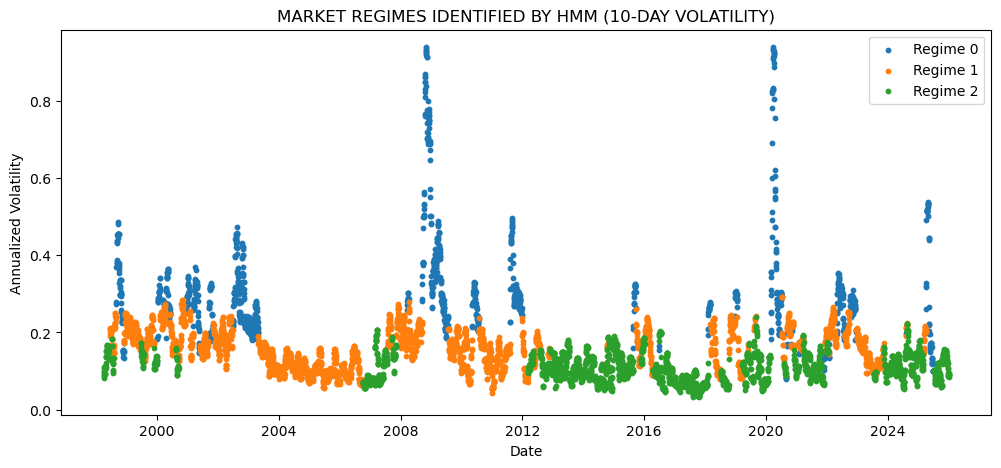

In [173]:
#VIZUALIZE REGIMES OVER TIME VIA VOLATILITY
plt.figure(figsize=(12,5))

for regime_id in range(n_regimes):
    mask = data_regimes["regime"] == regime_id
    plt.scatter(
        data_regimes.index[mask],
        data_regimes.loc[mask, "spy_vol_20d"],
        label=f"Regime {regime_id}",
        s=10
    )

plt.title("MARKET REGIMES IDENTIFIED BY HMM (10-DAY VOLATILITY)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.show()

In [174]:
#REGIME STATISTICS
regime_summary = (
    data_regimes
    .groupby("regime")
    .agg(
        mean_return=("spy_log_return","mean"),
        volatility_20d=("spy_vol_20d","mean"),
        volatility_60d=("spy_vol_60d","mean"),
        observations=("regime","count")
    )                 
)

print(regime_summary)

        mean_return  volatility_20d  volatility_60d  observations
regime                                                           
0         -0.000240        0.318444        0.314830          1241
1          0.000270        0.155313        0.162047          3118
2          0.000678        0.105911        0.113691          2627


In [175]:
#LABELS
regime_summary = regime_summary.sort_values("volatility_20d")
regime_summary

,mean_return,volatility_20d,volatility_60d,observations
regime,,,,
2,0.000678,0.105911,0.113691,2627
1,0.000270,0.155313,0.162047,3118
0,-0.000240,0.318444,0.314830,1241


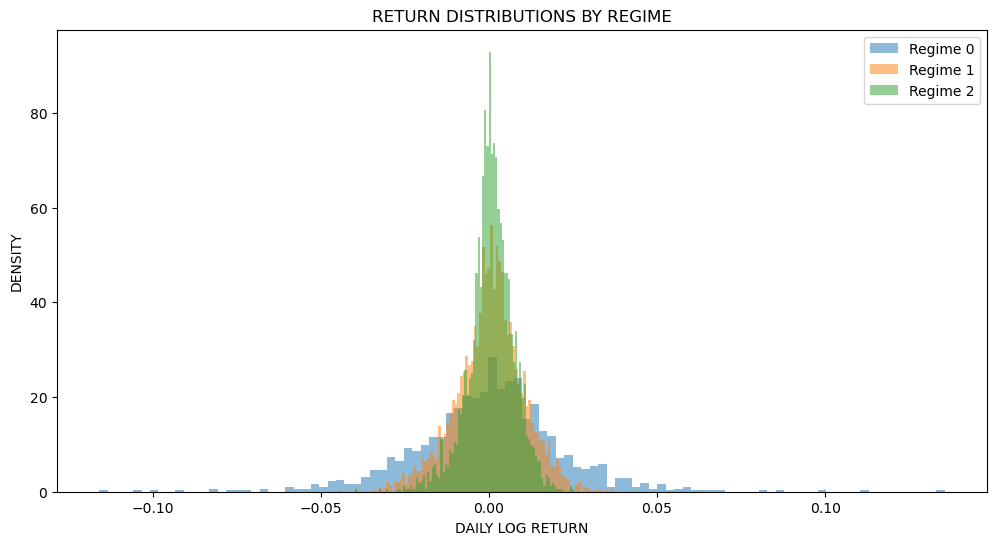

In [176]:
#REGIME-LEVEL RETURN DISTRIBUTIONS

plt.figure(figsize=(12,6))

for regime_id in sorted(data_regimes["regime"].unique()):
    returns = data_regimes.loc[
        data_regimes["regime"] == regime_id,
        "spy_log_return"
    ]
    plt.hist(
        returns,
        bins=100,
        alpha=0.5,
        label=f"Regime {regime_id}",
        density=True
    )

plt.title("RETURN DISTRIBUTIONS BY REGIME")
plt.xlabel("DAILY LOG RETURN")
plt.ylabel("DENSITY")
plt.legend()
plt.show()

In [177]:
#REGIME DURATION

#TEMPORAL
regime_changes = data_regimes["regime"].diff().fillna(0) !=0
data_regimes["regime_change"] = regime_changes

regime_runs = (
    data_regimes["regime"]
    .ne(data_regimes["regime"].shift())
    .cumsum()
)

run_lengths = (
    data_regimes
    .groupby(regime_runs)
    .size()
)

print(run_lengths.describe())

count     98.000000
mean      71.285714
std      112.997674
min        1.000000
25%       16.000000
50%       40.000000
75%       68.000000
max      867.000000
dtype: float64


In [178]:
#TRANSITION MATRIX

transition_matrix = hmm_model.transmat_

transition_df = pd.DataFrame(
    transition_matrix,
    columns=[f"TO REGIME {i}" for i in range(n_regimes)],
    index=[f"FROM REGIME {i}" for i in range(n_regimes)]
)

print(transition_df)

               TO REGIME 0  TO REGIME 1  TO REGIME 2
FROM REGIME 0     0.973766     0.023800     0.002433
FROM REGIME 1     0.007132     0.985260     0.007608
FROM REGIME 2     0.003961     0.006258     0.989781


In [186]:
#RISK METRICS BY REGIME

risk_summary = (
    data_regimes
    .groupby("regime")
    .agg(
        mean_return=("spy_log_return", "mean"),
        std_return=("spy_log_return","std"),
        var_5pct=("spy_log_return", lambda x: np.percentile(x, 5)),
        max_drawdown=("drawdown","min"),
        obs=("regime","count")
    )
)

print(risk_summary)

        mean_return  std_return  var_5pct  max_drawdown   obs
regime                                                       
0         -0.000240    0.022287 -0.035379     -0.551894  1241
1          0.000270    0.010045 -0.017400     -0.376884  3118
2          0.000678    0.006829 -0.011289     -0.060230  2627


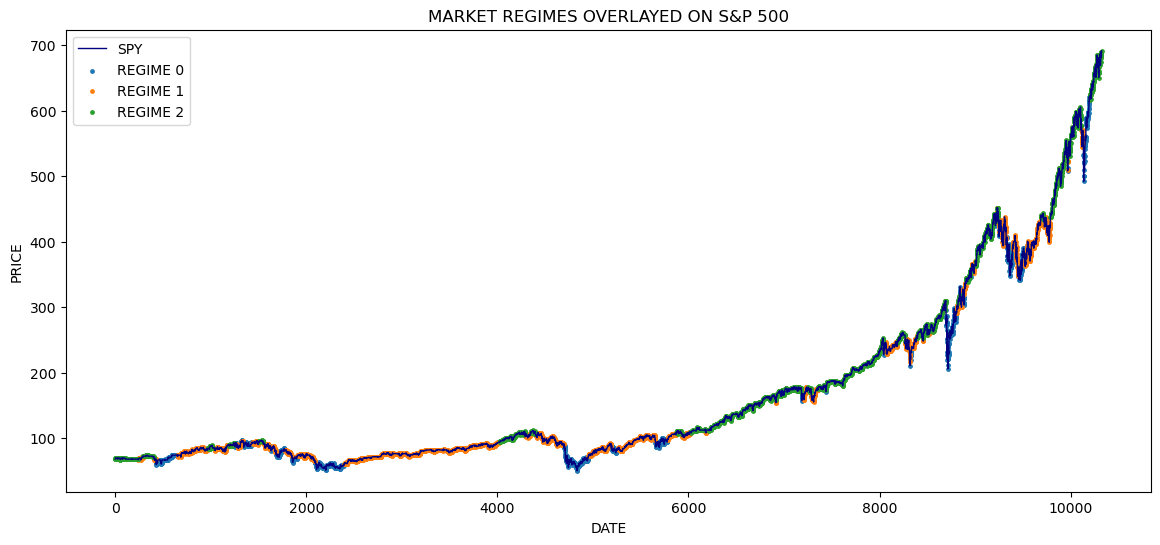

In [195]:
# VISUALIZE REGIMES ON PRICE SERIES
data_regimes = data_regimes.merge(
    data.loc[:, ["spy_adj_close"]],
    how="left"
)

plt.figure(figsize=(14,6))

plt.plot(
    data_regimes.index,
    data_regimes["spy_adj_close"],
    color="Navy",
    linewidth=1,
    label="SPY"
)

for regime_id in range(n_regimes):
    mask = data_regimes["regime"] == regime_id
    plt.scatter(
        data_regimes.index[mask],
        data_regimes.loc[mask, "spy_adj_close"],
        s=6,
        label=f"REGIME {regime_id}"
    )


plt.title("MARKET REGIMES OVERLAYED ON S&P 500")
plt.xlabel("DATE")
plt.ylabel("PRICE")
plt.legend()
plt.show()